In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from dlomix.losses import masked_spectral_distance, masked_pearson_correlation_distance
from dlomix.data import FragmentIonIntensityDataset

import os

In [3]:
int_data = FragmentIonIntensityDataset.load_from_disk("/nfs/home/students/d.lochert/projects/astral/dlomix-astral/balanced_dataset")

In [29]:
import zipfile

model_name = 'b_r_single_both_d5_static_0.0005_C0O'

with zipfile.ZipFile('/cmnfs/proj/prosit_astral/saved_models/final_models/%s.keras' % model_name,"r") as zip_ref:
    zip_ref.extractall("/nfs/home/students/d.lochert/projects/astral/dlomix-astral/unzip")

In [30]:
%load_ext autoreload
%autoreload 2

from models.models import TransformerModel
import yaml

with open("/nfs/home/students/d.lochert/projects/astral/dlomix-astral/config.yaml", 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)

model_settings = config['model_settings']
train_settings = config['train_settings']

print("Loading Transformer Model")

model = TransformerModel(**model_settings, seed=train_settings['seed'])

optimizer = tf.keras.optimizers.Adam(learning_rate=train_settings['lr_base'])

print("Compiling Transformer Model")
model.compile(optimizer=optimizer, 
            loss=masked_spectral_distance,
            metrics=[masked_pearson_correlation_distance])
inp = [m for m in int_data.tensor_train_data.take(1)][0][0]

out = model(inp)
model.summary()

# Load weights
model.load_weights('/nfs/home/students/d.lochert/projects/astral/dlomix-astral/unzip/model.weights.h5')

print(len(int_data.tensor_train_data))
print(len(int_data.tensor_val_data))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading Transformer Model
Compiling Transformer Model
Model: "transformer_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           multiple                  6656      
                                                                 
 dense_151 (Dense)           multiple                  2048      
                                                                 
 dense_152 (Dense)           multiple                  131584    
                                                                 
 trans_block_30 (TransBlock  multiple                  524545    
 )                                                               
                                                                 
 trans_block_31 (TransBlock  multiple                  524545    
 )                                   

493
62


In [32]:
eval_batches = [m for m in int_data.tensor_val_data.take(62)]

pred = []
true = []

for j in range(len(eval_batches)):

    predictions = model.predict(eval_batches[j][0], verbose=0)

    pred += np.split(predictions,        predictions.shape[0], axis=0) 
    true += np.split(eval_batches[j][1], predictions.shape[0], axis=0) 

    if j % 10 == 0:
        print(j)

pred = np.concatenate(pred, axis=0)
true = np.concatenate(true, axis=0)

print('Loss: ', tf.reduce_mean( masked_spectral_distance(true, pred) ))

0
10
20
30
40
50
60
Loss:  tf.Tensor(0.19515716, shape=(), dtype=float32)


In [33]:
masked_spectral_distance(true, pred)

np.save(
    '/nfs/home/students/d.lochert/projects/astral/dlomix-astral/plots/ablation/prosit_%s_eval.npy' % model_name,
    masked_spectral_distance(true, pred).numpy(),
)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f31c0318f70>],
 'cmeans': <matplotlib.collections.LineCollection at 0x7f31ec77f340>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f31c031bdf0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f31c0319120>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f31c0318760>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7f31c03181c0>}

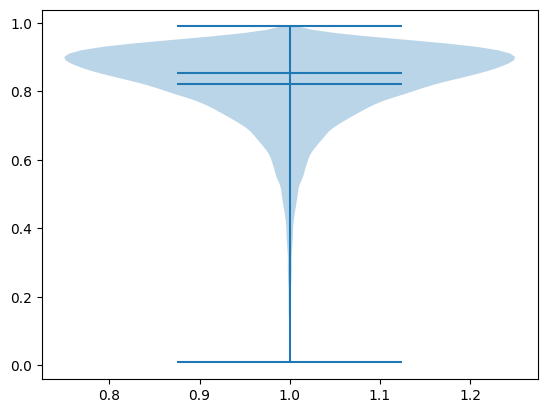

In [57]:
# i want to plot the loss using a violin plot
# the values should all be 1 - loss

spectral_angles = 1 - masked_spectral_distance(true, pred)

plt.violinplot(spectral_angles, showmeans=True, showmedians=True)


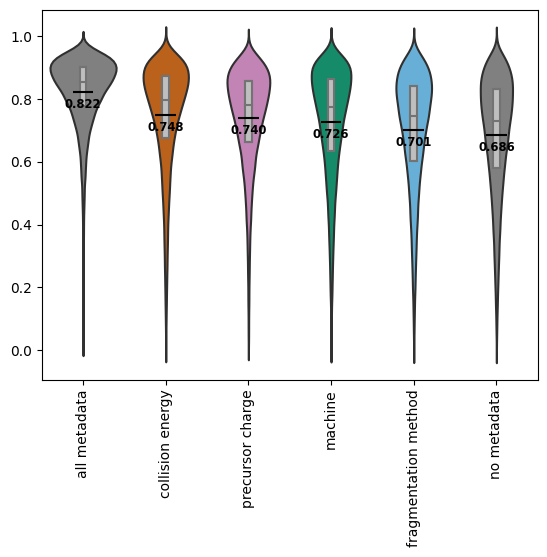

In [224]:
import seaborn as sns

# get all file path in the directory

directory = '/nfs/home/students/d.lochert/projects/astral/dlomix-astral/plots/ablation'

# List all files in the directory with their full paths
file_paths = [os.path.join(directory, file) for file in os.listdir(directory)]

file_paths.sort()

file_paths = [
    '/nfs/home/students/d.lochert/projects/astral/dlomix-astral/plots/ablation/allmeta_b_r_single_both_d5_static_0.0005_fNw_eval.npy',
    '/nfs/home/students/d.lochert/projects/astral/dlomix-astral/plots/ablation/+ener_b_r_single_both_d5_static_0.0005_zje_eval.npy',
    '/nfs/home/students/d.lochert/projects/astral/dlomix-astral/plots/ablation/+char_b_r_single_both_d5_static_0.0005_igr_eval.npy',
    '/nfs/home/students/d.lochert/projects/astral/dlomix-astral/plots/ablation/+mach_b_r_single_both_d5_static_0.0005_xyj_eval.npy',
    '/nfs/home/students/d.lochert/projects/astral/dlomix-astral/plots/ablation/+meth_b_r_single_both_d5_static_0.0005_hx1_eval.npy',
    '/nfs/home/students/d.lochert/projects/astral/dlomix-astral/plots/ablation/nometa_b_r_single_both_d5_static_0.0005_zNh_eval.npy',
]

file_names = [
    'all metadata',
    'collision energy',
    'precursor charge',
    'machine',
    'fragmentation method',
    'no metadata',
]

# Load all the files
data = [1- np.load(file) for file in file_paths]

colors = [
    'grey', 
    '#d55e00', 
    '#cc78bc', 
    '#029e73', 
    '#56b4e9', 
    'grey', 
]  


sns.violinplot(data, palette=colors, showmeans=True, showextrema=False, inner=None, )

sns.boxplot(data, width=.08, showfliers=False, whis=0, boxprops={'zorder': 2}, color='#bfbfbf')

violin_parts = plt.violinplot(data, showmeans=True, showmedians=False, showextrema=False, positions=list(range(len(data))))

for pc in violin_parts['bodies']:
    pc.set_visible(False) 

violin_parts['cmeans'].set_color('#000000')

# Calculate mean values and annotate them
means = [np.mean(d) for d in data]
for i, mean in enumerate(means):
    plt.text(i + .0, mean - .05, f'{mean:.3f}', horizontalalignment='center', size='small', color='black', weight='semibold')



plt.xticks(range(len(file_names)), file_names, rotation=90)

plt.show()

In [157]:
violin_parts


['/nfs/home/students/d.lochert/projects/astral/dlomix-astral/plots/ablation/+char_b_r_single_both_d5_static_0.0005_igr_eval.npy',
 '/nfs/home/students/d.lochert/projects/astral/dlomix-astral/plots/ablation/+ener_b_r_single_both_d5_static_0.0005_zje_eval.npy',
 '/nfs/home/students/d.lochert/projects/astral/dlomix-astral/plots/ablation/+mach_b_r_single_both_d5_static_0.0005_xyj_eval.npy',
 '/nfs/home/students/d.lochert/projects/astral/dlomix-astral/plots/ablation/+meth_b_r_single_both_d5_static_0.0005_hx1_eval.npy',
 '/nfs/home/students/d.lochert/projects/astral/dlomix-astral/plots/ablation/allmeta_b_r_single_both_d5_static_0.0005_fNw_eval.npy',
 '/nfs/home/students/d.lochert/projects/astral/dlomix-astral/plots/ablation/nometa_b_r_single_both_d5_static_0.0005_zNh_eval.npy']

In [46]:
# get all file path in the directory
directory = '/nfs/home/students/d.lochert/projects/astral/dlomix-astral/plots/ablation'

# List all files in the directory with their full paths
file_paths = [os.path.join(directory, file) for file in os.listdir(directory)]

file_paths

# create empty pandas dataframe
import pandas as pd

data = pd.DataFrame()

# load files with column name loss with another column for the file name

for file in file_paths:

    print(pd.DataFrame({
        'loss': 1 - np.load(file), 'file': [file.split('/')[-1].split('_')[0]]*63000
    }, index=[0]))

    data = pd.concat([data, pd.DataFrame({
        'loss': 1 - np.load(file), 'file': [file.split('/')[-1].split('_')[0]]*63000
    }, index=[0])])

data


           loss    file
0      0.908862  prosit
1      0.735892  prosit
2      0.935671  prosit
3      0.930379  prosit
4      0.700256  prosit
...         ...     ...
62995  0.761900  prosit
62996  0.686444  prosit
62997  0.511963  prosit
62998  0.738922  prosit
62999  0.631594  prosit

[63000 rows x 2 columns]


ValueError: Length of values (63000) does not match length of index (1)